<a href="https://colab.research.google.com/github/8AquA8/2024-SRC-Summer-Program/blob/main/SRC_day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Introduction to Genetic Algorithms**
**Genetic Algorithms (GAs)** are search heuristics inspired by the process of natural selection. They are used to solve optimization and search problems by mimicking the principles of biological evolution.

#### **Key Concepts**
Population: A set of potential solutions.

Chromosomes: Representation of a solution.

Genes: Parts of a chromosome, analogous to variables.

Fitness Function: Evaluates how close a given solution is to the optimum.

#### **How It Works**
Initialization: Generate an initial population.

Selection: Select the fittest individuals.

Crossover: Combine pairs to produce offspring.

Mutation: Introduce random changes.

Evaluation: Assess the fitness of the new generation.

Termination: Repeat the process until a satisfactory solution is found.

**Step 1: Initialization**

Randomly generate a population of potential solutions. For example, binary strings can represent possible solutions.

**Step 2: Selection**

Choose individuals based on their fitness. Techniques include:

Roulette Wheel Selection: Individuals are selected based on their proportionate fitness.
Tournament Selection: A few individuals are chosen randomly, and the fittest among them is selected.

**Step 3: Crossover**

Combine pairs of individuals to create offspring. Methods include:

Single-point crossover: A single crossover point is selected, and the genetic material is exchanged between the parents.
Multi-point crossover: Multiple crossover points are selected.

**Step 4: Mutation**

Introduce random changes to individual genes to ensure diversity within the population. This step helps prevent premature convergence to local optima.

**Step 5: Evaluation**

Assess the fitness of each individual in the new generation using the fitness function to determine how close each solution is to the optimum.

**Termination**

The algorithm stops when a satisfactory solution is found or a maximum number of generations is reached.

**Example Application: Traveling Salesman Problem**

The Traveling Salesman Problem (TSP) is a classic optimization problem where the goal is to find the shortest possible route that visits each city exactly once and returns to the origin city. Genetic algorithms can be used to find an optimal route for TSP by representing each route as a chromosome and using crossover and mutation to explore different routes.

#### **Advantages and Disadvantages**
**Advantages:**

Can solve complex problems with a large search space.
Flexible and adaptable.


**Disadvantages:**

Computationally expensive.
May not always find the global optimum.
Conclusion
Genetic algorithms mimic natural evolution to solve optimization problems. They are powerful but computationally intensive and are widely used in various fields including engineering, economics, and artificial intelligence.


### Importing packages and Global Settings

In [ ]:
from google.colab import drive
import os, sys
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [ ]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# GA
POOL_SIZE = 20
TOURNAMENT_SIZE = 5
MAX_ITERATION = 100000

# SA
MAX_EVALUATION = 100
SUB_ITERATIONS = 50
TEMPERATURE = 100
COOLING_RATIO = 0.5
TEMP_LIMIT = 1

np.random.seed(0)
# Plot Settings
PLOT_MODE = True # Draw Route
plt.ion()

# First City Index
FIRST_IDX = 0

In [ ]:
file_path = '/content/gdrive/MyDrive/data1.txt'

### Load Data

In [ ]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = int(items[1]), int(items[2])

    return coord_list

### Initialization

In [ ]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

### Path search (Genetic Algorithm)

In [ ]:
def two_opt_swap(path_map, path, iterations, coord_list):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()

    for i in range(iterations):
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost

    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO
    return best_path, best_cost

In [ ]:
def sa(path_map, path, coord_list):
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()

    for i in range(MAX_EVALUATION):
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost

    return best_path, best_cost

In [ ]:
def initialization(coord_list):
    cnt_cities = len(coord_list)
    path_pool = np.zeros((POOL_SIZE, cnt_cities + 1), dtype=np.int32)
    pool_cost = np.zeros(POOL_SIZE)

    path_map, path_pool[0, :] = initialize_greedy(coord_list, FIRST_IDX)
    pool_cost[0] = path_cost(path_map, path_pool[0, :]).sum()

    print('Path {} is initialized'.format(0))

    for i in range(1, POOL_SIZE):
        _, path_pool[i, :] = initialize_random(coord_list, FIRST_IDX)
        path_pool[i, :], pool_cost[i] = sa(path_map, path_pool[i, :], coord_list)
        print('Path {} is initialized'.format(i))

    return path_pool, pool_cost, path_map

In [ ]:
#selects the lowest cost path among the pool from tournament
def selection(pool_cost, TOURNAMENT_SIZE, sel_size=2):
    # tournament selection
    sel_idx = np.random.choice(POOL_SIZE, TOURNAMENT_SIZE, replace=False)
    sel_cost = pool_cost[sel_idx]
    best_idx = sel_idx[np.argsort(sel_cost)][:sel_size]
    return best_idx

In [ ]:
# pmx crossover
def crossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Initialize child path
    child_path = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path[0], child_path[-1] = -1, -1
    # Copy the path between crossover points
    child_path[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    # Copy the rest of the path from path2
    path2_idx = np.where(np.isin(path2, child_path) == False)[0]
    child_path[np.where(child_path == 0)[0]] = path2[path2_idx]
    child_path[0], child_path[-1] = FIRST_IDX, FIRST_IDX

    return child_path

In [ ]:
# swap mutation
def mutation(path):
    cnt_cities = len(path)
    child_path = path.copy()
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])

    return child_path

In [ ]:
# genetic algorithm
def ga(coord_list):
    best_cost = np.Inf
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        # crossover
        child_crx = crossover(path_pool[sel_idx[0]], path_pool[sel_idx[1]])
        cost_crx = path_cost(path_map, child_crx).sum()

        # mutation
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1) # might be better if we mutate the highest cost path-> 아닌듯..
        child_mut = mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)

        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx # cost가 가장 높은 path를 이번 GA에서 구한 child로 대체
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut # cost가 두번째로 높은 path를 이번에 mutation한 child로 대체

        cur_idx = np.argmin(pool_cost)
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]

        if best_cost > cur_cost:
            best_cost = cur_cost
            if PLOT_MODE: #GA알고리즘을 통해 구한 path가 기존의 best path보다 좋은 경우에 plot
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')

                ax.annotate('Cost: {:.2f}'.format(best_cost),
                    xy=(1, 1), xycoords='axes fraction',
                    fontsize=10, xytext=(-5, -5),
                    textcoords='offset points',
                    ha='right', va='top')


                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx]

Start Genetic Algorithm
Initialize the population
Path 0 is initialized
Path 1 is initialized
Path 2 is initialized
Path 3 is initialized
Path 4 is initialized
Path 5 is initialized
Path 6 is initialized
Path 7 is initialized
Path 8 is initialized
Path 9 is initialized
Path 10 is initialized
Path 11 is initialized
Path 12 is initialized
Path 13 is initialized
Path 14 is initialized
Path 15 is initialized
Path 16 is initialized
Path 17 is initialized
Path 18 is initialized
Path 19 is initialized
Start the evolution


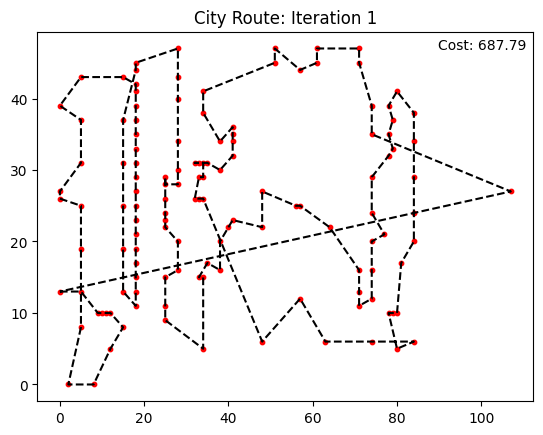

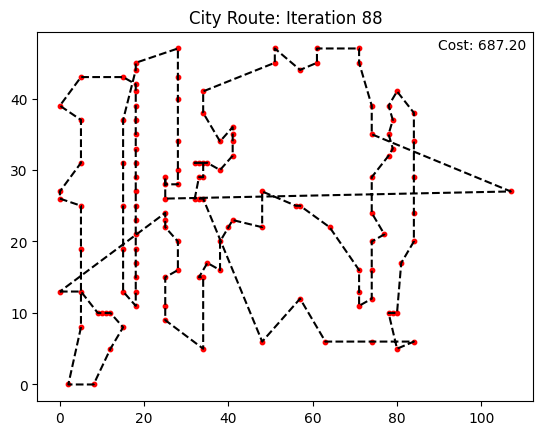

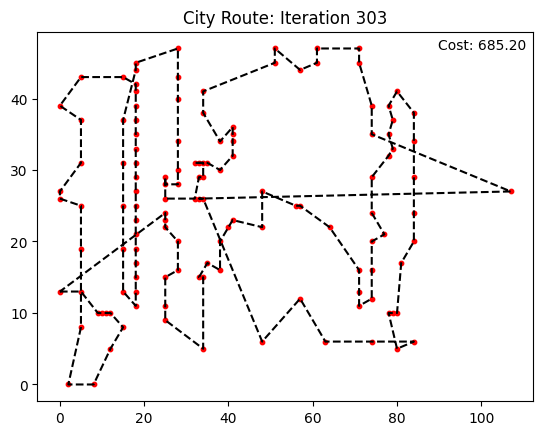

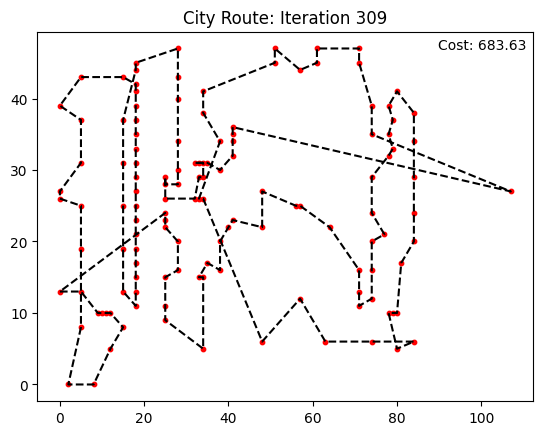

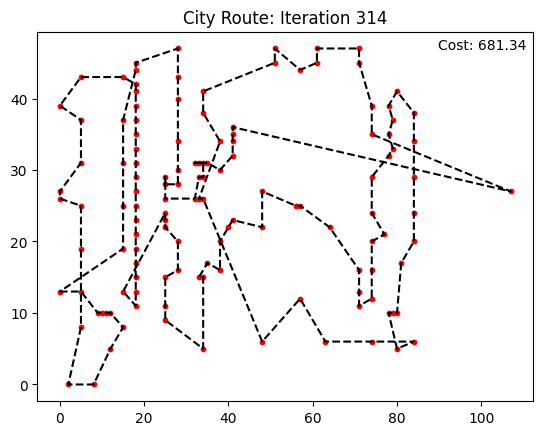

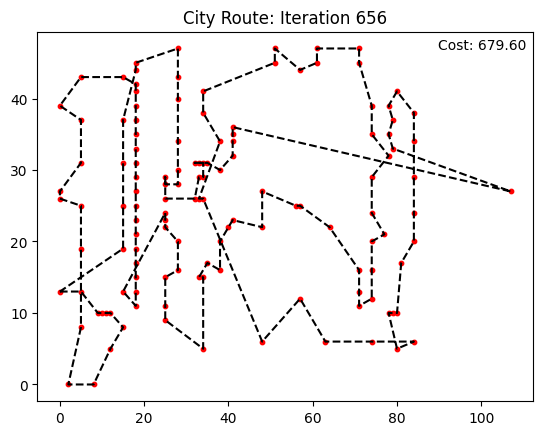

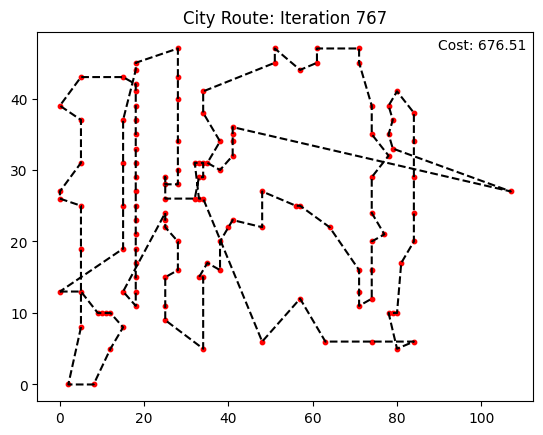

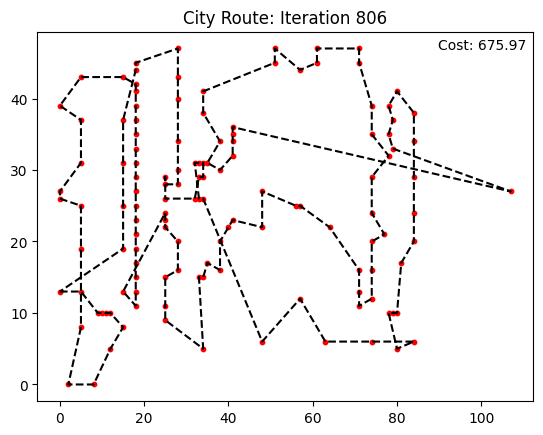

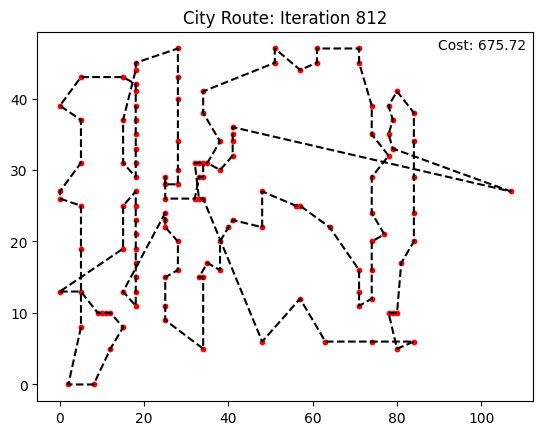

Iteration 1000


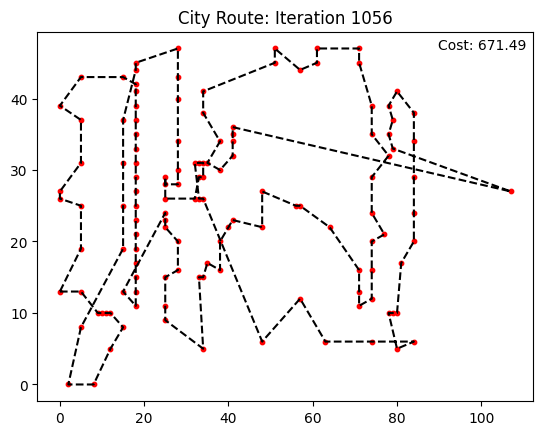

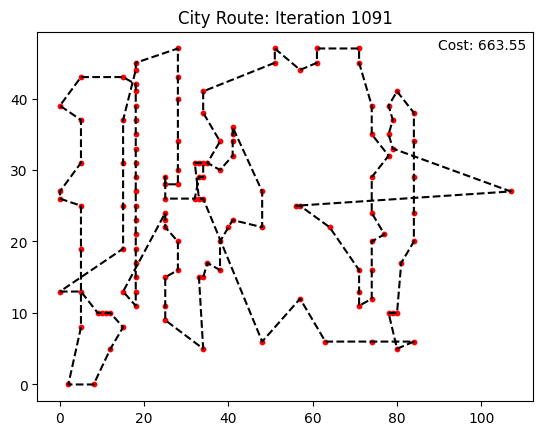

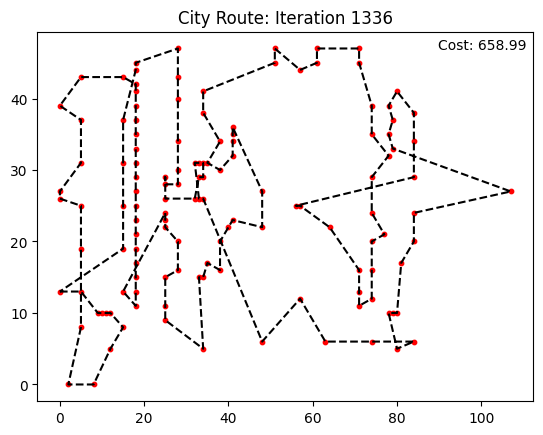

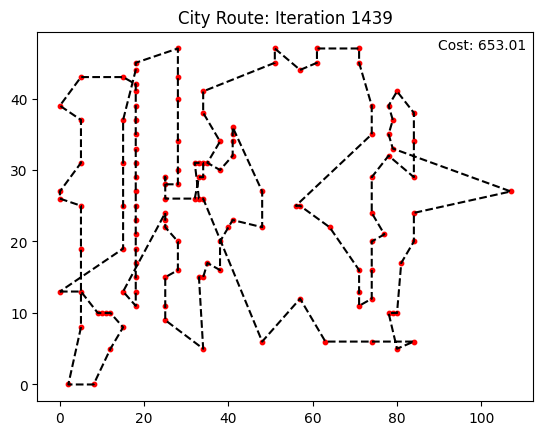

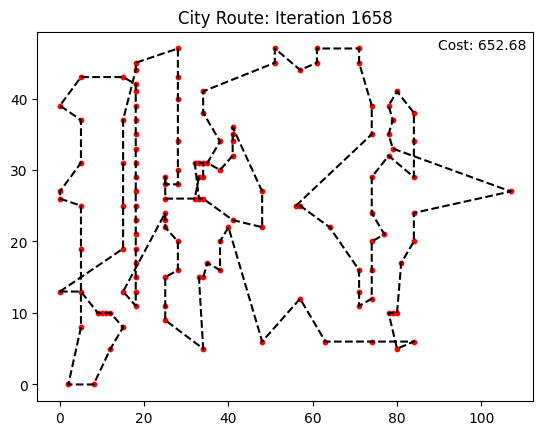

Iteration 2000


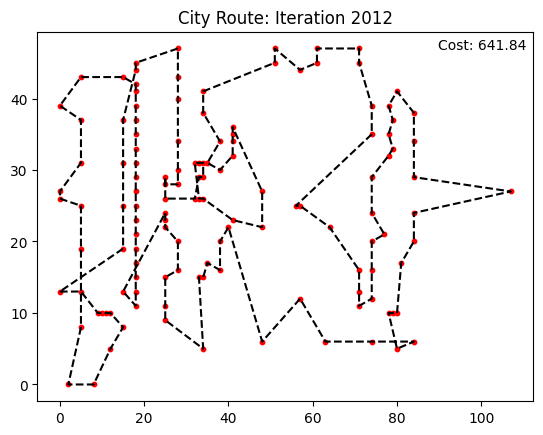

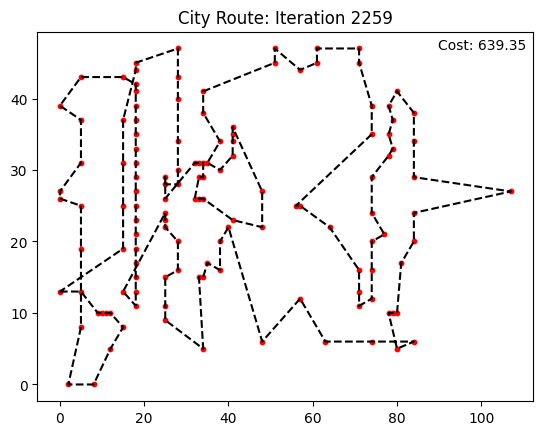

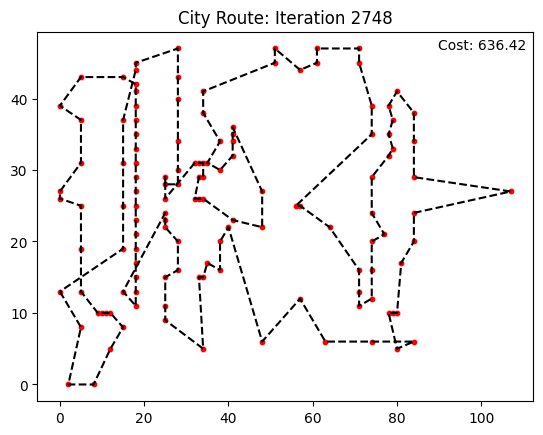

Iteration 3000


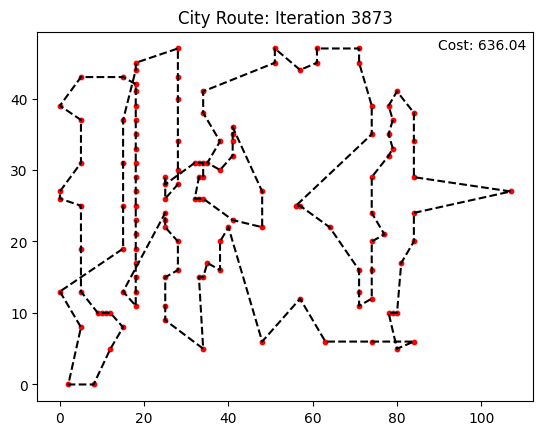

Iteration 4000


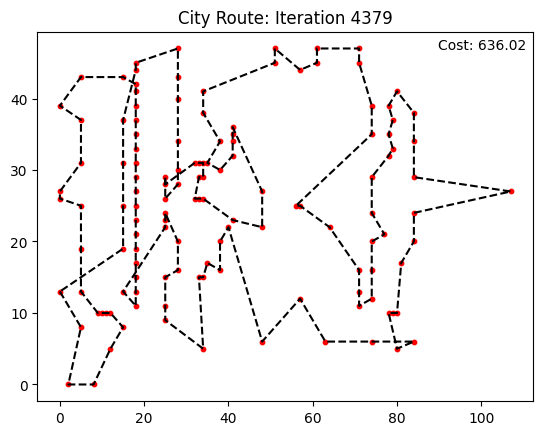

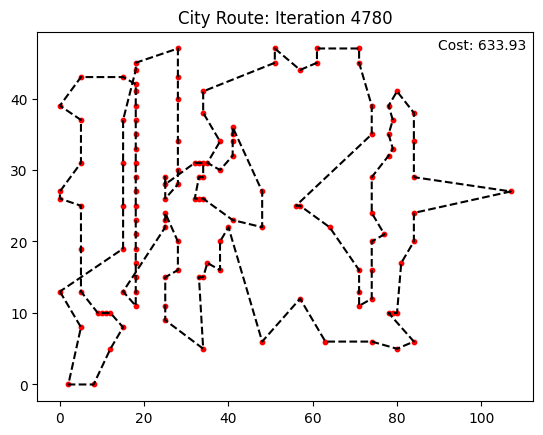

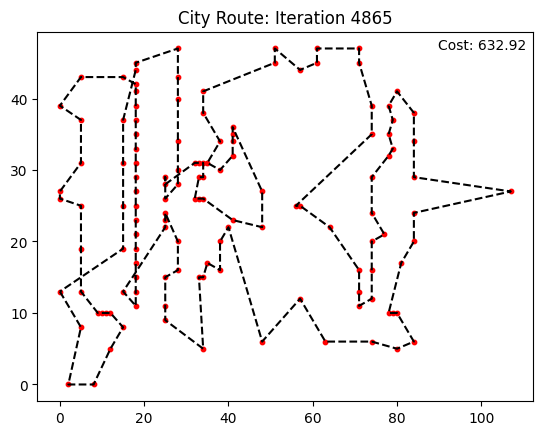

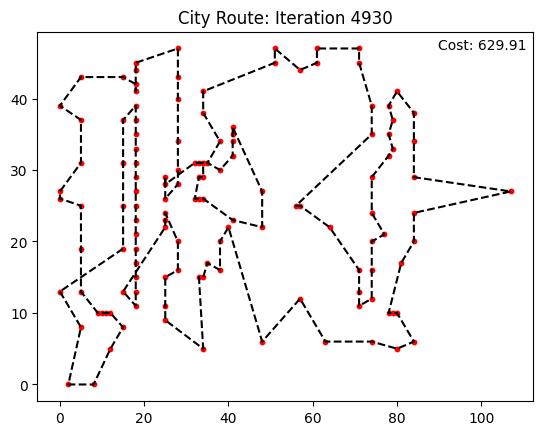

Iteration 5000
Iteration 6000
Iteration 7000


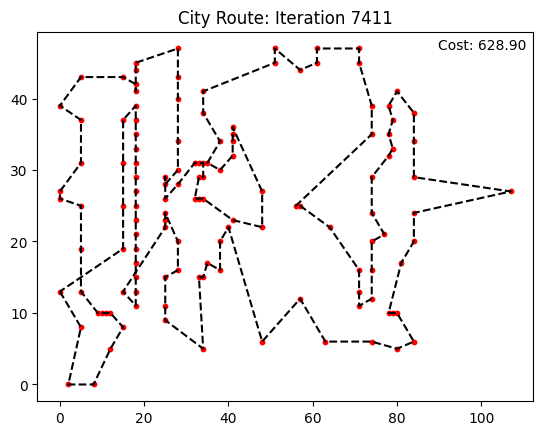

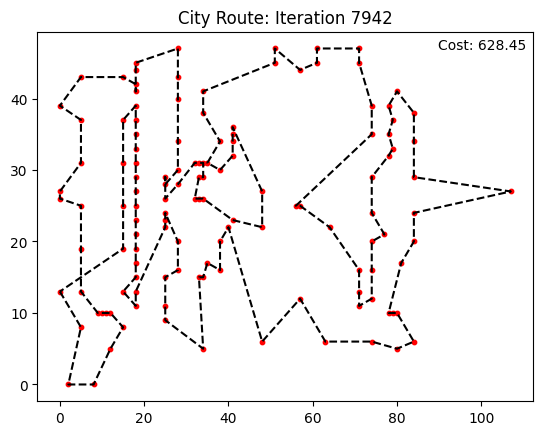

Iteration 8000


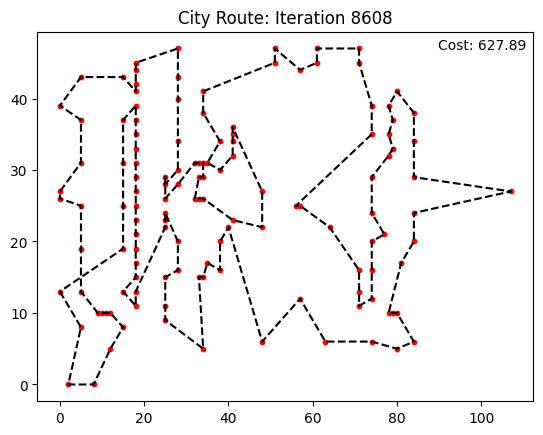

Iteration 9000
Iteration 10000
Iteration 11000


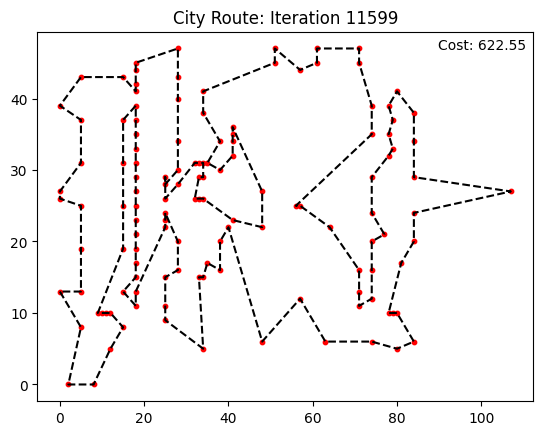

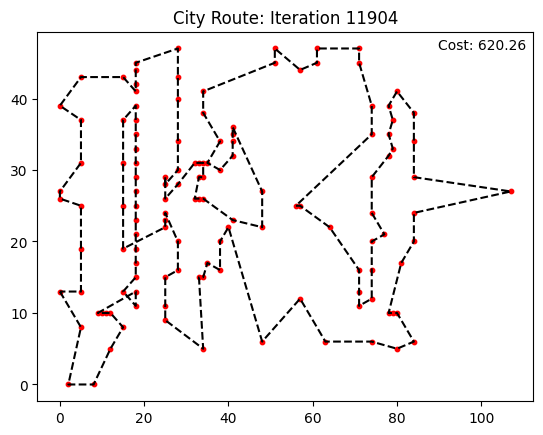

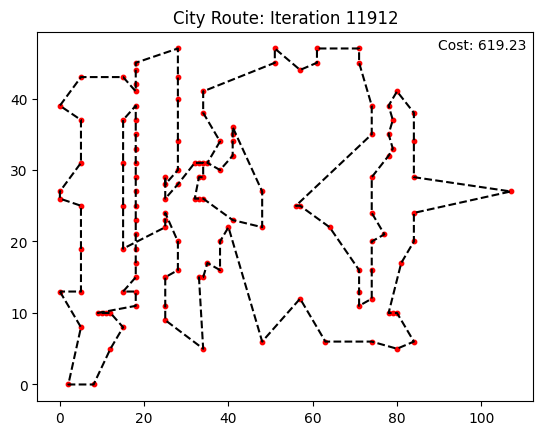

Iteration 12000


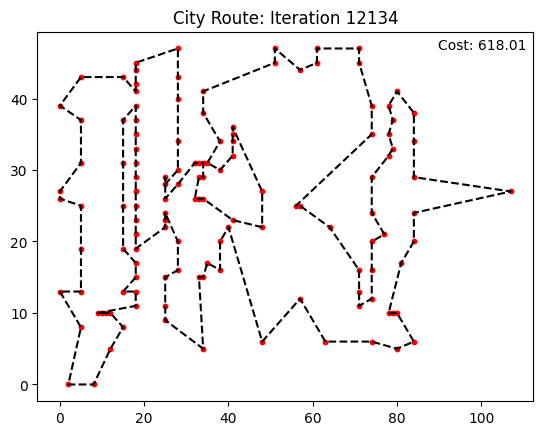

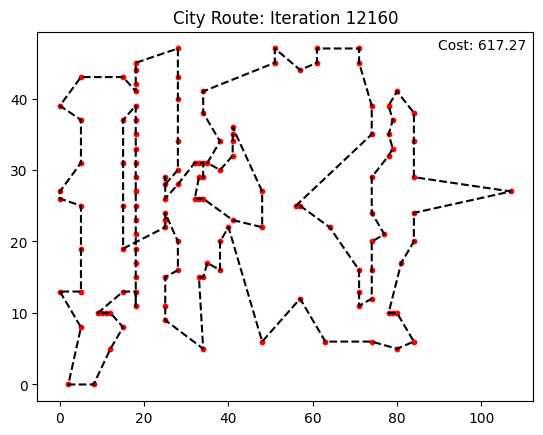

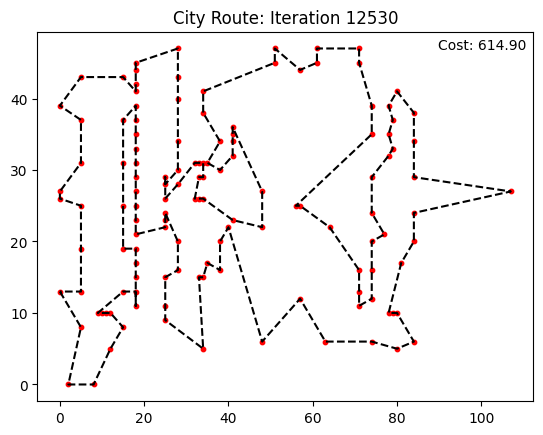

Iteration 13000


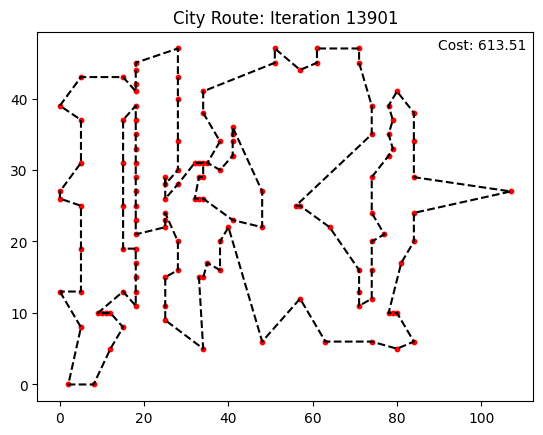

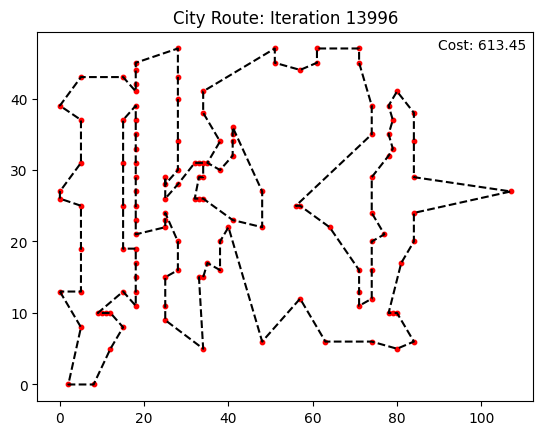

Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Iteration 20000
Iteration 21000


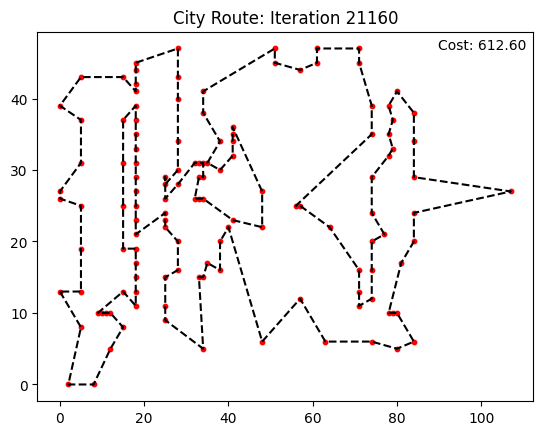

Iteration 22000


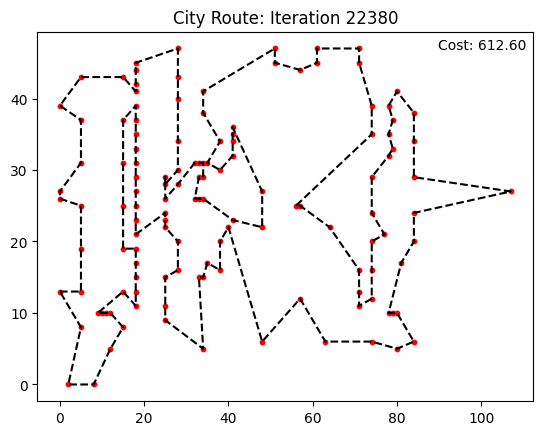

Iteration 23000


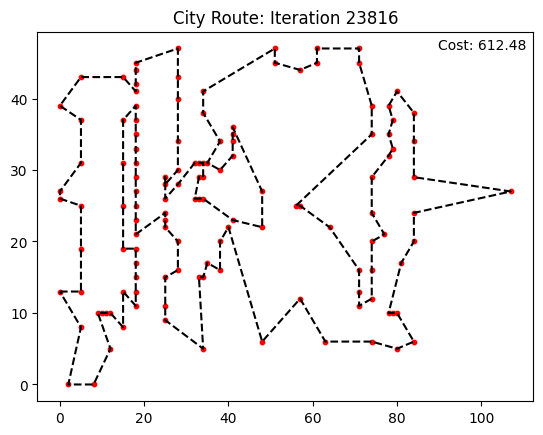

Iteration 24000
Iteration 25000
Iteration 26000
Iteration 27000
Iteration 28000
Iteration 29000
Iteration 30000
Iteration 31000
Iteration 32000
Iteration 33000
Iteration 34000
Iteration 35000


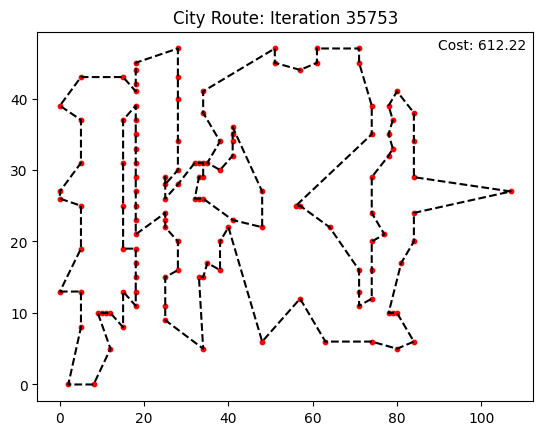

Iteration 36000


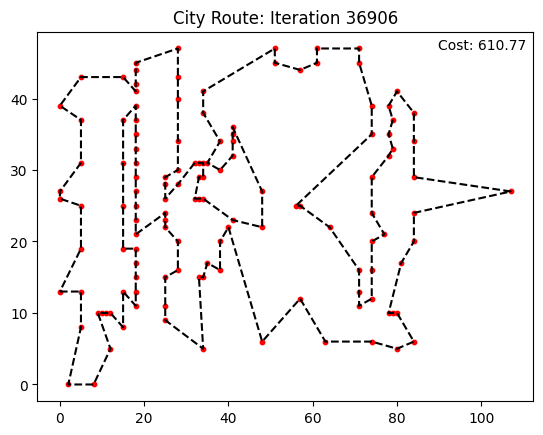

Iteration 37000
Iteration 38000
Iteration 39000
Iteration 40000
Iteration 41000
Iteration 42000
Iteration 43000
Iteration 44000
Iteration 45000
Iteration 46000
Iteration 47000
Iteration 48000
Iteration 49000
Iteration 50000
Iteration 51000
Iteration 52000
Iteration 53000
Iteration 54000
Iteration 55000
Iteration 56000
Iteration 57000
Iteration 58000
Iteration 59000
Iteration 60000
Iteration 61000
Iteration 62000
Iteration 63000
Iteration 64000
Iteration 65000
Iteration 66000
Iteration 67000
Iteration 68000
Iteration 69000
Iteration 70000
Iteration 71000
Iteration 72000
Iteration 73000
Iteration 74000
Iteration 75000
Iteration 76000
Iteration 77000
Iteration 78000
Iteration 79000
Iteration 80000
Iteration 81000
Iteration 82000
Iteration 83000
Iteration 84000
Iteration 85000
Iteration 86000
Iteration 87000
Iteration 88000
Iteration 89000
Iteration 90000
Iteration 91000
Iteration 92000
Iteration 93000
Iteration 94000
Iteration 95000
Iteration 96000
Iteration 97000
Iteration 98000
Iteratio

In [ ]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))